In [ ]:
!pip3 install torch torchvision

In [66]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as functional
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

Experiment configuration.

In [137]:
# Mathematical function to approximate.
def f(x):
    return x * x

# Training data parameters.
x_min = -20
x_max = 20
x_increment = 0.1 # For visualization
train_count = 1024
seed = torch.Generator().manual_seed(10)
learning_rate = 1e-1
epochs= 100
batch_size = 10
optimizer_f = torch.optim.Adam

# The dimensions of each layer
layer_dimensions = [(1, 2),(2, 1)]

# Loss function
loss_f = nn.MSELoss()

# Device (cpu or gpu)
device = "cpu"

A fully connected neural network (FNN) that approximates the given mathematical function for the given input range.

In [138]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()

        self.layers = nn.ModuleList()

        for i in range(0, len(layer_dimensions)):
            in_dim = layer_dimensions[i][0]
            out_dim = layer_dimensions[i][1]
            self.layers.append(nn.Linear(in_dim, out_dim))

    def forward(self, x):
        for i in range(0, len(self.layers)):
            layer = self.layers[i]

            if i == len(self.layers) - 1:
                # Last layer does not use an activation function
                x = layer(x)
            else:
                x = functional.relu(layer(x))

        return x

The training procedure.

Epoch   100 | loss_train=0.20305 | loss_validation=0.19333


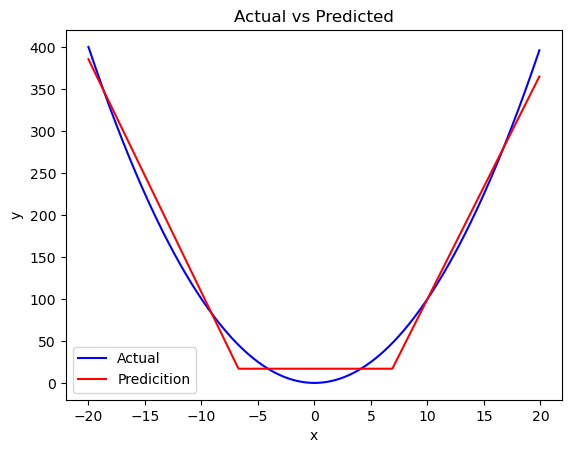

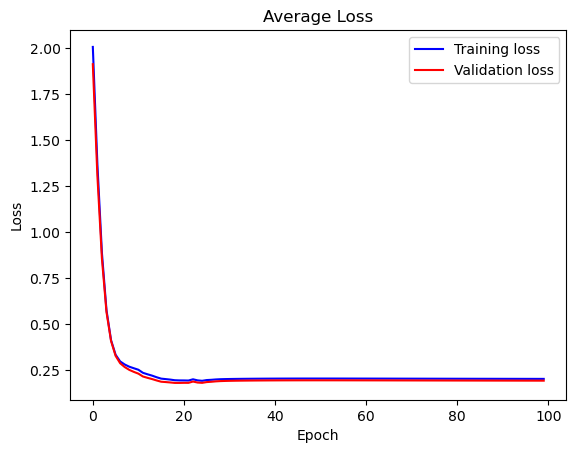

In [140]:
model = FNN()
model.to(device)

x_train = (x_max - x_min) * torch.rand(train_count, 1, generator=seed) + x_min
x_validation = (x_max - x_min) * torch.rand(train_count, 1, generator=seed) + x_min

y_train = f(x_train)
y_validation = f(x_validation)

x_train = x_train.to(device)
y_train = y_train.to(device)

dataset_train = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset_train, batch_size=batch_size)

optimizer = optimizer_f(model.parameters(), lr=learning_rate)

training_losses = []
validation_losses = []

for epoch in range(1, epochs + 1):
    model.train()
    
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss_train = loss_f(model(x_batch), y_batch)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

    model.eval()
    
    with torch.no_grad():
        loss_train = loss_f(model(x_train), y_train).detach().cpu().item() / x_train.shape[0];
        training_losses.append(loss_train)
        
        loss_validation = loss_f(model(x_validation), y_validation).detach().cpu().item() / x_validation.shape[0];
        validation_losses.append(loss_validation)
    
    if epoch != 0:
        print("\r", end="")

    print(f"Epoch {epoch:5d} | loss_train={loss_train:.5f} | loss_validation={loss_validation:.5f}", end="")

print("")

x = torch.arange(x_min, x_max, x_increment).unsqueeze(1)
y_actual = f(x)
y_prediction = model(x)

x = x.tolist()
y_actual = y_actual.tolist()
y_prediction = y_prediction.tolist()

plt.title("Actual vs Predicted")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x, y_actual, 'b-', label="Actual")
plt.plot(x, y_prediction, 'r-', label="Predicition")
plt.legend()
plt.show()

epoch_list = list(range(0, 100, 1))
plt.title("Average Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epoch_list, training_losses, 'b-', label="Training loss")
plt.plot(epoch_list, validation_losses, 'r-', label="Validation loss")
plt.legend()
plt.show()